# 本文档介绍换乘规则的选定

## 换乘条件
1.  中转时间＜30分钟，中转距离＜300m。
2. “中转时间/公交乘车时间”<1
3. 对于前后乘车流距离在2KM内的，选取角度<150°；距离在2KM外的，无要求。

从数据量上，各层过滤后的占比如图：

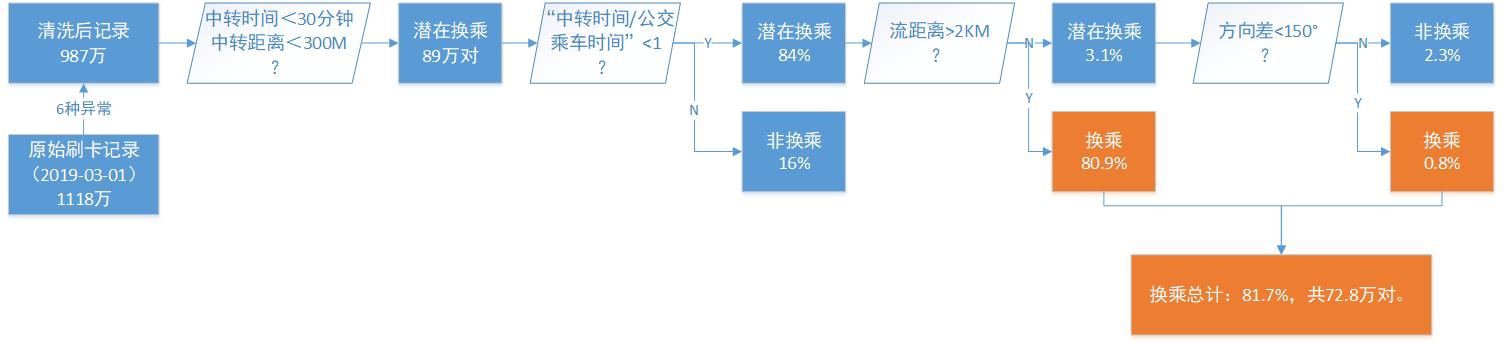

## 条件解释

### 条件1：中转时间＜30分钟，中转距离＜300m。

换乘的初筛条件是中转时间＜30分钟，中转距离＜300m。具体地，设前一次乘车起终点为A1,A2，后一次乘车的起终点为B1,B2。若在A2下车与在B1上车的时间差小于30分钟,距离差小于300m，则这两次乘车满足初步的换乘条件。

但并非满足上述条件的所有乘车对均是换乘，因为可能存在30分钟内办完事情又返程的情况，所以需要把非换乘关系进一步过滤掉。

### 条件2：“中转时间/公交乘车时间”<1
**非换乘关系包括两种：（1）在中转点办事，返回起点，即往返程。 （2）在中转点办事，又前往下一个地点。**非换乘关系的特点在于，中转站停留时间相对较长。而对于换乘，人们一般难以忍受换乘时间多于公交乘车时间的的方案。若“中转时间/公交乘车时间”>=1，再考虑到初步条件的中转时间＜30分钟，则意味着在公交乘车时间小于30分钟的情况下，换乘比乘车时间还要长。因此考虑以“中转时间/公交乘车时间”<1作为判断换乘与否的第二层标准。

对于非换乘中的往返程关系，其有两个特点：**（1）往返的上下车点相距较近。**即除了A2与B1较近，A1与B2也应较近。为了度量两次乘车之间的距离，以流的视角，借用论文[1]中的公式：$fd=\sqrt{d_{O}^{2}+d_{D}^{2}}$，其中$d_{O}$指A1与B2的距离，$d_{D}$指A2与B1的距离。往返程关系中的流距离fd应较小，而换乘的fd应较大。**（2）往返的方向角度差应接近180°。**

如果比值“中转时间/公交乘车时间”<1判断为潜在换乘的条件合理，那么，在潜在换乘组，中转时间相对较小，fd相对较大，方向差平均也应相对较小。

下面验证猜想:

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [4]:
path='e:\\RESEARCH\\Transportation\\script\\amap_transport\\data'
# path=os.path.join(os.getcwd(), 'data')
data=pd.read_csv(path+'\\data-30mins300m.csv')
data['degree']=data.apply(lambda k: k['degree'] if k['degree']<=180 else 360-k['degree'],axis=1)
data.f_tm_stamp_come=pd.to_datetime(data.f_tm_stamp_come)
data.t_tm_stamp_come=pd.to_datetime(data.t_tm_stamp_come)
data.f_tm_stamp_back=pd.to_datetime(data.f_tm_stamp_back)
data.t_tm_stamp_back=pd.to_datetime(data.t_tm_stamp_back)
data['transfer_time']=(data.f_tm_stamp_back-data.t_tm_stamp_come)/np.timedelta64(1,'s')
data['trans_time_ratio']=data['transfer_time']/((data.t_tm_stamp_come-data.f_tm_stamp_come+data.t_tm_stamp_back-data.t_tm_stamp_back)/np.timedelta64(1,'s'))

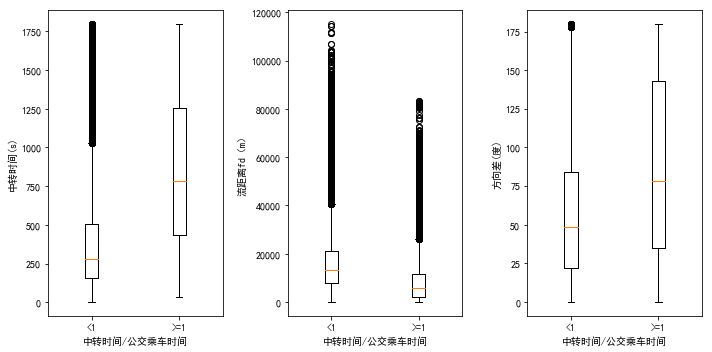

In [71]:
degree=[data['degree'][data.trans_time_ratio<1],data['degree'][data.trans_time_ratio>=1]]
fds=[data['fds'][data.trans_time_ratio<1],data['fds'][data.trans_time_ratio>=1]]
fd=[data['fd'][data.trans_time_ratio<1],data['fd'][data.trans_time_ratio>=1]]
transfer_time=[data['transfer_time'][data.trans_time_ratio<1],data['transfer_time'][data.trans_time_ratio>=1]]

fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(10,5))
ax[0].boxplot(transfer_time,labels=['<1','>=1'])
ax[1].boxplot(fd,labels=['<1','>=1'])
ax[2].boxplot(degree,labels=['<1','>=1'])
ylabels=[u'中转时间(s)',u'流距离fd（m）',u'方向差(度)']
for i,a in enumerate(ax):
    a.set_xlabel(u'中转时间/公交乘车时间')
    a.set_ylabel(ylabels[i])
fig.tight_layout()
plt.show()

由箱线图可知，平均来讲，对于潜在换乘组[0,1)组，中转时间较短，前后乘车流距离较大，方向差较小，说明以1为阈值比较合理。

### 条件3：排除流距离在2KM内且方向差在150°以上的记录

由箱线图的可知，对于比值<1的潜在换乘组，其流距离有很小甚至接近0的情况，但真实情况下，换乘的流距离应该偏大。对于流距离较小的情况，更可能是往返程，需要把往返程过滤掉。如前介绍，往返程的方向夹角应较大，这里以150°为阈值。那149°就不算往返程了吗？实际上，随着角度的减小，往返程逐渐变成非换乘关系的第二种，即前往下一个目的地。该情况和换乘其实比较难以区分。检查了几个实例后，很难判断是换乘还是前往下一个目的地。不过这部分比例很小，即使差上10度，占比只变化千分之5。可以认为是大数据中本来就存在的模糊性吧。